In [1]:
import os
import torch
import numpy as np
import PIL
from PIL import Image
import time
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import copy
import pandas as pd

from tqdm import tqdm
from torch.utils import data

from torchvision.datasets import VisionDataset
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from typing import Optional, Callable

import torchvision
from torch.utils.data.dataloader import DataLoader


In [2]:
def encode_labels(target):
    k = np.zeros((10))
    return torch.from_numpy(k)

In [3]:
# #download data
# image = torchvision.datasets.VOCDetection(root='./data',year='2007',image_set='train',download = True, target_transform=encode_labels)


In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
    
class PascalVOC2007(VisionDataset):
    def __init__(self, voc_dataset_dir, size):        
        #Define dataset
        #In the training set, combine PASCAL VOC 2012 with SBD
        self.dataset = [torchvision.datasets.VOCDetection(root=voc_dataset_dir,year='2007',image_set='train',download = False, target_transform=encode_labels)]
        self.origin_size = size 
    def __len__(self):
        return 2000
    
    def __getitem__(self, idx):
        if idx < len(self.dataset[0]):
            chosen_dataset = self.dataset[0]
        else:
            chosen_dataset = self.dataset[1]
            idx = idx - len(self.dataset[0])
        imagepil, targetpil = chosen_dataset[idx]
        
        image = trans_img(imagepil, origin_size)
        noisy_image = trans_img(imagepil, origin_size, True)
#         transform_to_grayscale = transforms.Grayscale(num_output_channels=3)
#         image_gray = transform_to_grayscale(image)
        return image, noisy_image#image_gray

def trans_img(img, size, noise=False):
    if noise:
        ChosenTransforms = torchvision.transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
            AddGaussianNoise(0., 0.1)
        ])
    else:
        ChosenTransforms = torchvision.transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
        ]) 

    image = ChosenTransforms(img)
    image = image.unsqueeze(0)
    image = torch.nn.functional.interpolate(image,size=(size,size),mode='bilinear', align_corners=False)
    image = image.squeeze()
    return image


In [5]:
origin_size = 256

data_dir = './data/TrainVal/VOCdevkit/VOC2007/JPEGImages/'
dataset = PascalVOC2007("./data", size=origin_size)#./data
              

train, val, test = torch.utils.data.random_split(dataset, [int(0.6*len(dataset)),
                                                     int(0.39*len(dataset)),
                                                     int(0.01*len(dataset)),
                                                    ])

batch_size = 16
num_workers = 16

dataloaders = {
    'train': torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers),
    'val': torch.utils.data.DataLoader(val, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers),
}

# dataloaders = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                           shuffle=False, num_workers=2)

dataset_sizes = {x: len(dataloaders[x]) for x in ['train', 'val', 'test']}
# dataset_sizes = len(dataloaders)
print('dataset_sizes: ', dataset_sizes)

dataset_sizes:  {'train': 75, 'val': 49, 'test': 2}


In [6]:
len(dataset)

2000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


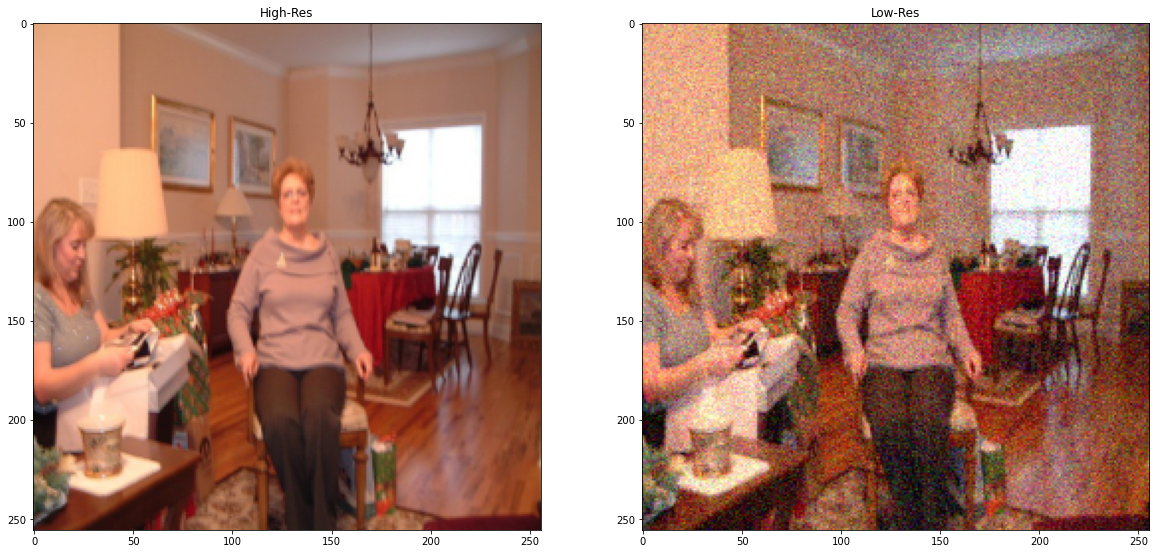

In [7]:
for i in dataloaders['train']:
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(i[0][0].permute(1, 2, 0))
    axarr[1].imshow(i[1][0].permute(1, 2, 0))
    axarr[0].set_title("High-Res")
    axarr[1].set_title("Low-Res")
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


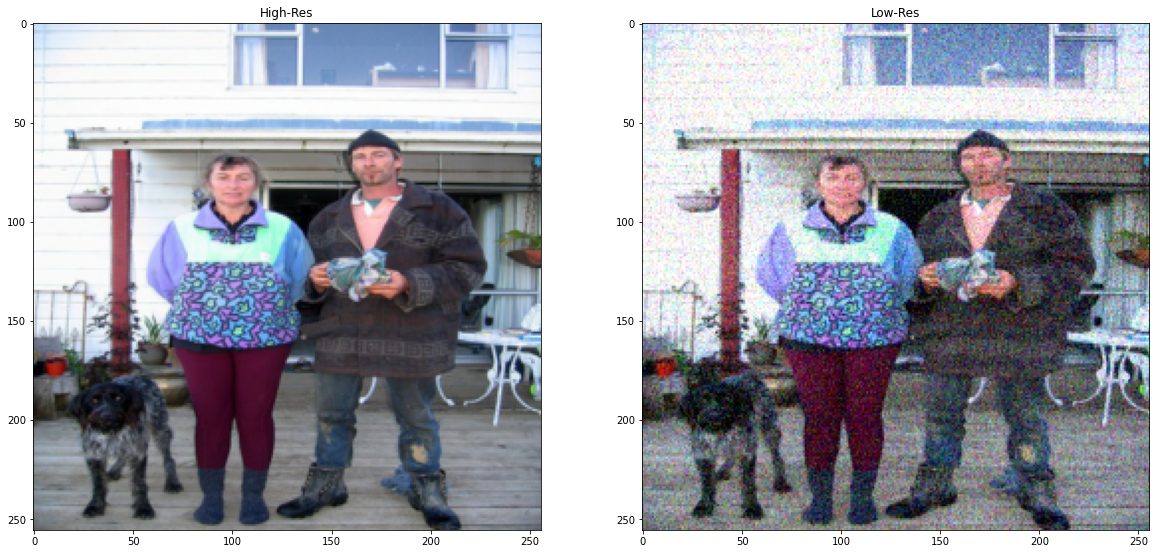

In [8]:
for i in dataloaders['val']:
    f, axarr = plt.subplots(1,2, figsize=(20,20))
    axarr[0].imshow(i[0][0].permute(1, 2, 0))
    axarr[1].imshow(i[1][0].permute(1, 2, 0))
    axarr[0].set_title("High-Res")
    axarr[1].set_title("Low-Res")
    break

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512), dec_chs=(512, 256, 128, 64), num_class=3, retain_dim=False, out_sz=(255,255)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz  = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = torch.nn.functional.interpolate(out, self.out_sz)
        return out

In [11]:
model = UNet(retain_dim=True, out_sz=(origin_size,origin_size))

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

model = model.to(device)

Let's use 4 GPUs!


In [12]:
def PSNR(original, compressed):
    mse = torch.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20. * torch.log10(max_pixel / torch.sqrt(mse))
    return psnr

def normalize_batch(batch):
    # normalize using imagenet mean and std
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
#     batch = batch.div(255.0)
    return (batch - mean) / std


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
from collections import namedtuple

import torch
from torchvision import models


class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [14]:
vgg = Vgg16(requires_grad=True).to(device)

In [15]:
def calc_perceptual_loss(vgg, img1,img2):
    outputs_vgg = vgg(img1)
    ground_truth_vgg = vgg(img2)
    loss1_2 = criterion(outputs_vgg.relu1_2, ground_truth_vgg.relu1_2)
    loss2_2 = criterion(outputs_vgg.relu2_2, ground_truth_vgg.relu2_2)
    loss3_3 = criterion(outputs_vgg.relu3_3, ground_truth_vgg.relu3_3)
    loss4_3 = criterion(outputs_vgg.relu4_3, ground_truth_vgg.relu4_3)
    loss = loss1_2 + loss2_2 + loss3_3 + loss4_3
    return loss

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    running_loss = []
    running_psnr = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
    # Init variables that will save info about the best model
#     best_model_wts = copy.deepcopy(model.state_dict())
#     vgg = models.vgg16(pretrained=True)
    
    best_weights = copy.deepcopy(model.state_dict())
    best_epoch = 0
    best_psnr = 100.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Set model to training mode. 
        model.train()  
        epoch_losses = AverageMeter()
        

        train_running_loss = 0.0
        val_running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for original_batch, transformed_batch in dataloaders['train']:
            optimizer.zero_grad(set_to_none=True)
            # Prepare the inputs for GPU/CPU
            original_batch = original_batch.to(device).float()
            transformed_batch = transformed_batch.to(device).float()

#             tensor_input = low_res_batch.float()
            outputs = model(transformed_batch)
            
            original_batch = normalize_batch(original_batch)
            transformed_batch = normalize_batch(transformed_batch)
            outputs = normalize_batch(outputs)
            
            loss = calc_perceptual_loss(vgg, outputs, original_batch)
            
            loss.backward() # Perform a step in the opposite direction of the gradient
            optimizer.step() # Adapt the optimizer

#             Collect statistics
            train_running_loss += loss.item()
            epoch_losses.update(train_running_loss, len(original_batch))


            # Adjust the learning rate based on the scheduler
        print('train loss: {:.5f}'.format(epoch_losses.avg / dataset_sizes['train'] ))
#         print('train psnr: {:.2f}'.format(epoch_psnr.avg))
        running_loss.append(epoch_losses.avg)
    
        model.eval()
        val_epoch_losses = AverageMeter()
        epoch_psnr = AverageMeter()

        for original_batch, transformed_batch in dataloaders['val']:
            original_batch = original_batch.to(device).float()
            transformed_batch = transformed_batch.to(device).float()

            with torch.no_grad():
                preds = model(transformed_batch)
                
                transformed_batch = normalize_batch(transformed_batch)
                original_batch = normalize_batch(original_batch)
                preds = normalize_batch(preds)

                loss_val = calc_perceptual_loss(vgg, preds, original_batch)
                val_running_loss += loss_val.item()
                
                val_epoch_losses.update(val_running_loss, len(original_batch))
                psnr = PSNR(transformed_batch, original_batch) - PSNR(preds, original_batch)
                epoch_psnr.update(psnr, len(original_batch))

        print('val loss: {:.5f}'.format(val_epoch_losses.avg / dataset_sizes['val'] ))
        print('psnr: {:.2f} (reconstructed:{:.5f} gray_scaled:{:.5f})'.format(epoch_psnr.avg, PSNR(preds, original_batch), PSNR(transformed_batch, original_batch)))

        avg_epoch_psnr = epoch_psnr.avg.cpu().detach().numpy()
        running_psnr.append(avg_epoch_psnr)
        if avg_epoch_psnr < best_psnr:
            best_epoch = epoch
            best_psnr = avg_epoch_psnr
            best_weights = copy.deepcopy(model.state_dict())
            print('--- New best - saving weights ---')
            
        print()
#         print('outputs',outputs)

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val psnr: {best_psnr:4f}')
    print(f'Best epoch: {best_epoch:4f}')

    # load best model weights
    model.load_state_dict(best_weights)
    return model, running_loss, running_psnr

In [16]:


# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.MSELoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
# optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

num_epochs = 10

In [ ]:
model, loss, psnr = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)

Epoch 0/9
----------
train loss: 11.80708
val loss: 11.20335
psnr: 11.07 (reconstructed:45.38481 gray_scaled:57.11475)
--- New best - saving weights ---

Epoch 1/9
----------
train loss: 11.57964
val loss: 11.42407
psnr: 10.89 (reconstructed:46.87549 gray_scaled:57.00010)
--- New best - saving weights ---

Epoch 2/9
----------
train loss: 11.57118
val loss: 11.24300
psnr: 10.99 (reconstructed:46.82465 gray_scaled:57.02500)

Epoch 3/9
----------
train loss: 11.66890
val loss: 11.33471
psnr: 11.04 (reconstructed:45.47767 gray_scaled:57.00990)

Epoch 4/9
----------


In [ ]:
model.eval()
for i in dataloaders['test']:
    input_img = i[1][0]
    inputs = input_img.to(device).float()
    out = model(inputs.unsqueeze(0))
    image = out.squeeze(0).permute(1, 2, 0).cpu().detach()

    f, axarr = plt.subplots(1,3, figsize=(20,20))
    axarr[0].imshow(i[0][0].permute(1, 2, 0), cmap='gray')
    axarr[1].imshow(inputs.cpu().permute(1, 2, 0), cmap='gray')
    axarr[2].imshow(image, cmap='gray')
    axarr[0].set_title("Original")
    axarr[1].set_title("GrayScale")
    axarr[2].set_title("Reconstructed")

In [ ]:
# image == i[1][0].permute(1, 2, 0)
print('reconstructed', PSNR(image, i[0][0].permute(1, 2, 0)).cpu().detach().numpy())
print('gray scaled', PSNR(i[1][0].permute(1, 2, 0), i[0][0].permute(1, 2, 0)).cpu().detach().numpy())

In [ ]:
f, axarr = plt.subplots(2,1, figsize=(5,5))
axarr[0].plot(loss[3:])
axarr[1].plot(psnr[3:])
axarr[0].set_title("loss")
axarr[1].set_title("psnr")

In [ ]:
# torch.save(model.state_dict(), 'model_weights_unet_same_img.pth')

In [ ]:
model.encoder